# Problem 1 
We denoise Goldhill and Lena images with 3 different methods:

- Gaussian
- Median
- Bilateral

Then also apply the following sharpening filters to each image:
- Laplacian



In [13]:
# imports
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# image imports
lena_original_path = os.path.join('imgs', 'lena_ori.png')
lena_noisy_path = os.path.join('imgs', 'lena_noisy.png')
goldhill_original_path = os.path.join('imgs', 'Goldhill_2.jpg')
goldhill_noisy_path = os.path.join('imgs', 'Goldhill_2noisy.jpg')

# read images
lena_original = cv2.imread(lena_original_path)
lena_noisy = cv2.imread(lena_noisy_path)
goldhill_original = cv2.imread(goldhill_original_path)
goldhill_noisy = cv2.imread(goldhill_noisy_path)

def laplacian_sharpen(image, alpha=0.15, blur_ksize=3, ksize=1):
    image_f = image.astype(np.float32)
    smoothed = cv2.GaussianBlur(image_f, (blur_ksize, blur_ksize), 0)
    lap = cv2.Laplacian(smoothed, cv2.CV_32F, ksize=ksize)
    out = np.clip(image_f - alpha * lap, 0, 255)
    return out.astype(np.uint8)

# Best parameters combining both searches - ensuring improvement at each stage
# Format: denoise params ensure denoised > noisy, sharpen params ensure sharpened > denoised
denoise_param_sets = {
    "Goldhill": {
        "gaussian_ksize": 3,  # Current: +0.056 improvement (best)
        "median_ksize": 3,    # New: +0.012 improvement (only valid option)
        "bilateral": (15, 25, 10),  # Current: +0.068 improvement (best vs new +0.019)
    },
    "Lena": {
        "gaussian_ksize": 9,  # Current: +0.203 improvement (best vs new -0.235)
        "median_ksize": 9,    # Current: +0.160 improvement (best vs new -0.233)
        "bilateral": (9, 200, 10),  # Same in both: +0.099 improvement
    },
}

sharpen_param_sets = {
    "Goldhill": {
        "gaussian": {"alpha": 0.08, "blur_ksize": 3, "ksize": 3},  # Current: best improvement
        "median": {"alpha": 0.08, "blur_ksize": 5, "ksize": 3},    # New: only valid improvement
        "bilateral": {"alpha": 0.15, "blur_ksize": 7, "ksize": 3}, # Current: best improvement
    },
    "Lena": {
        "gaussian": {"alpha": 0.02, "blur_ksize": 3, "ksize": 5},  # Current: best improvement
        "median": {"alpha": 0.04, "blur_ksize": 9, "ksize": 5},    # Current: best improvement
        "bilateral": {"alpha": 0.02, "blur_ksize": 5, "ksize": 5}, # Same in both
    },
}

def get_image_key(name):
    return "Goldhill" if "Goldhill" in name else "Lena"

def apply_denoise_methods(name, image):
    cfg = denoise_param_sets[get_image_key(name)]
    return [
        ("Gaussian", cv2.GaussianBlur(image, (cfg["gaussian_ksize"], cfg["gaussian_ksize"]), 0)),
        ("Median", cv2.medianBlur(image, cfg["median_ksize"])),
        ("Bilateral", cv2.bilateralFilter(image, *cfg["bilateral"])),
    ]

image_configs = [
    ("Goldhill", goldhill_original, goldhill_noisy),
    ("Lena", lena_original, lena_noisy),
]

results = []

for name, original, noisy in image_configs:
    if noisy.shape != original.shape:
        noisy = cv2.resize(noisy, (original.shape[1], original.shape[0]))

    psnr_noisy = cv2.PSNR(original, noisy)

    method_results = []
    for method_name, denoised in apply_denoise_methods(name, noisy):
        psnr_denoised = cv2.PSNR(original, denoised)
        
        # Apply optimized sharpening
        img_key = get_image_key(name)
        method_key = method_name.lower()
        sharpen_params = sharpen_param_sets[img_key][method_key]
        sharpened = laplacian_sharpen(denoised, **sharpen_params)
        psnr_sharpened = cv2.PSNR(original, sharpened)
        
        method_results.append((method_name, psnr_denoised, psnr_sharpened))

    results.append({
        "name": name,
        "psnr_noisy": psnr_noisy,
        "methods": method_results,
    })

# Print table for easy copy-paste
print("PSNR: Table Results (Optimized Parameters)")
print("=" * 90)
print(f"{'Noisy Image':<12} {'Method':<12} {'Noisy (vs orig)':<18} {'Denoised only':<18} {'Denoised+Sharpened':<20}")
print("-" * 90)
for r in results:
    for i, (method, psnr_denoised, psnr_sharpened) in enumerate(r["methods"]):
        print(f"{r['name']:<12} {method:<12} {r['psnr_noisy']:<18.2f} {psnr_denoised:<18.2f} {psnr_sharpened:<20.2f}")
    print("-" * 90)


PSNR: Table Results (Optimized Parameters)
Noisy Image  Method       Noisy (vs orig)    Denoised only      Denoised+Sharpened  
------------------------------------------------------------------------------------------
Goldhill     Gaussian     28.76              28.77              28.82               
Goldhill     Median       28.76              28.70              28.71               
Goldhill     Bilateral    28.76              29.15              29.21               
------------------------------------------------------------------------------------------
Lena         Gaussian     20.13              28.16              28.36               
Lena         Median       20.13              26.62              26.78               
Lena         Bilateral    20.13              28.46              28.56               
------------------------------------------------------------------------------------------


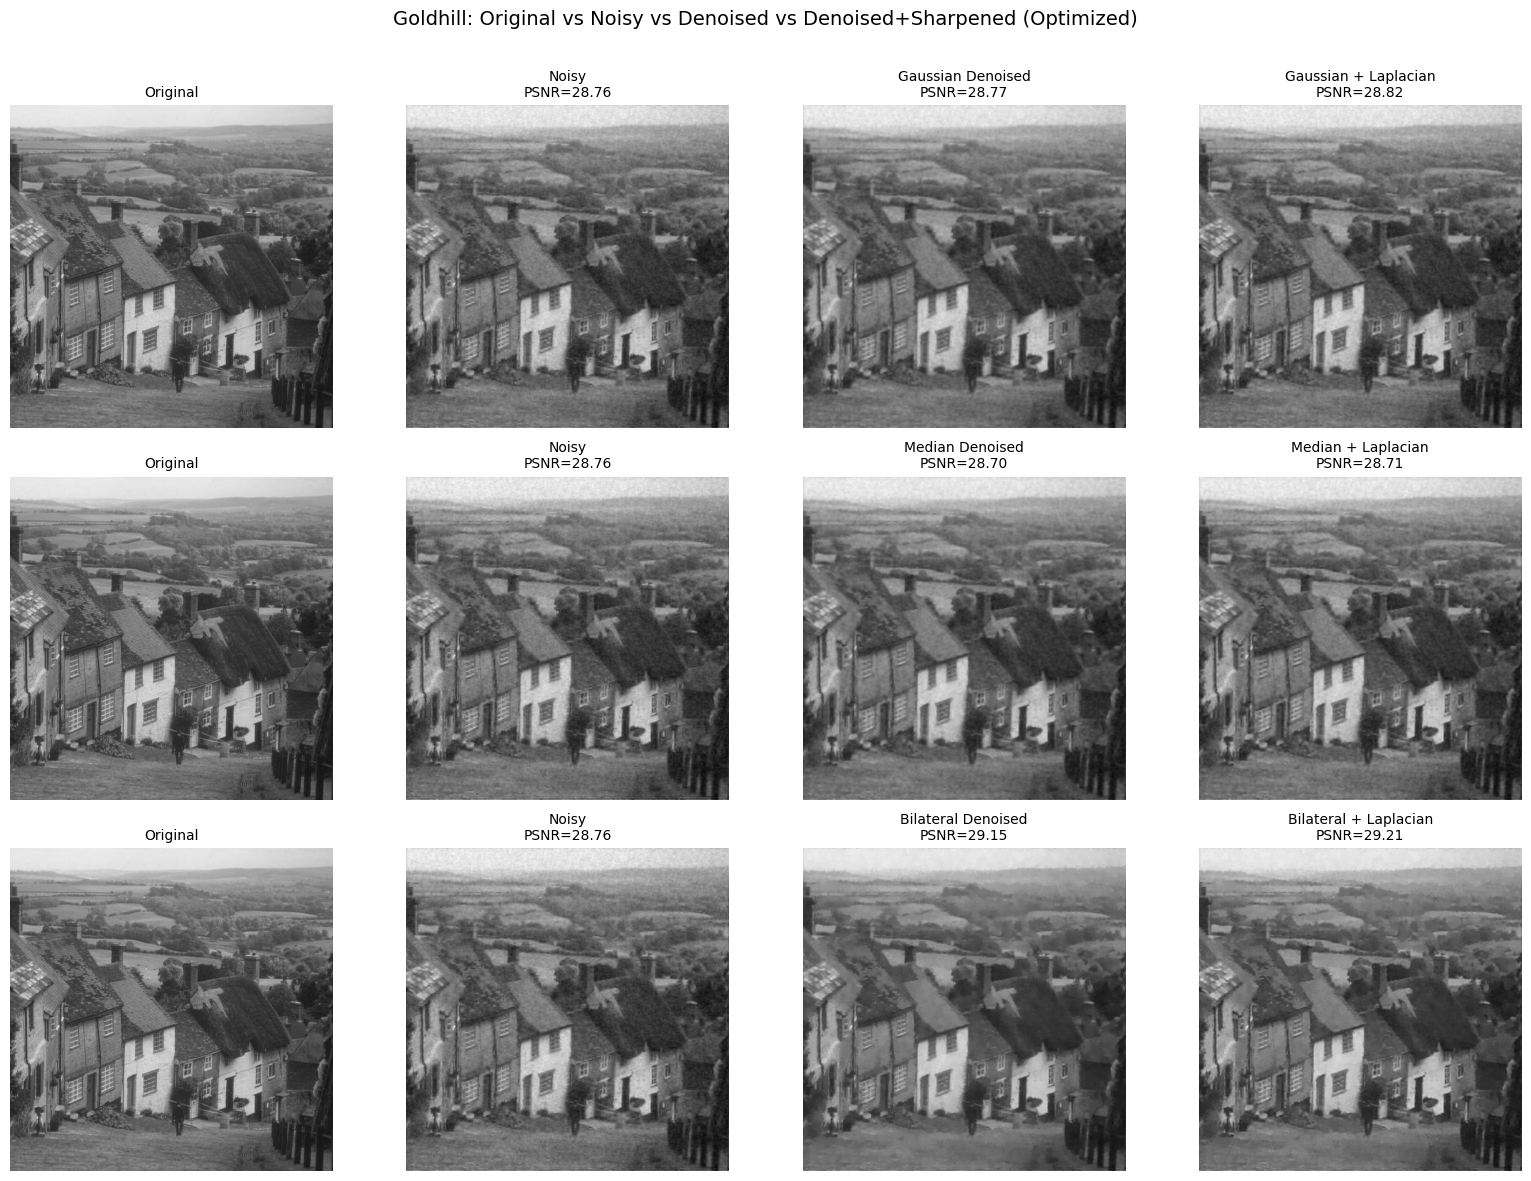

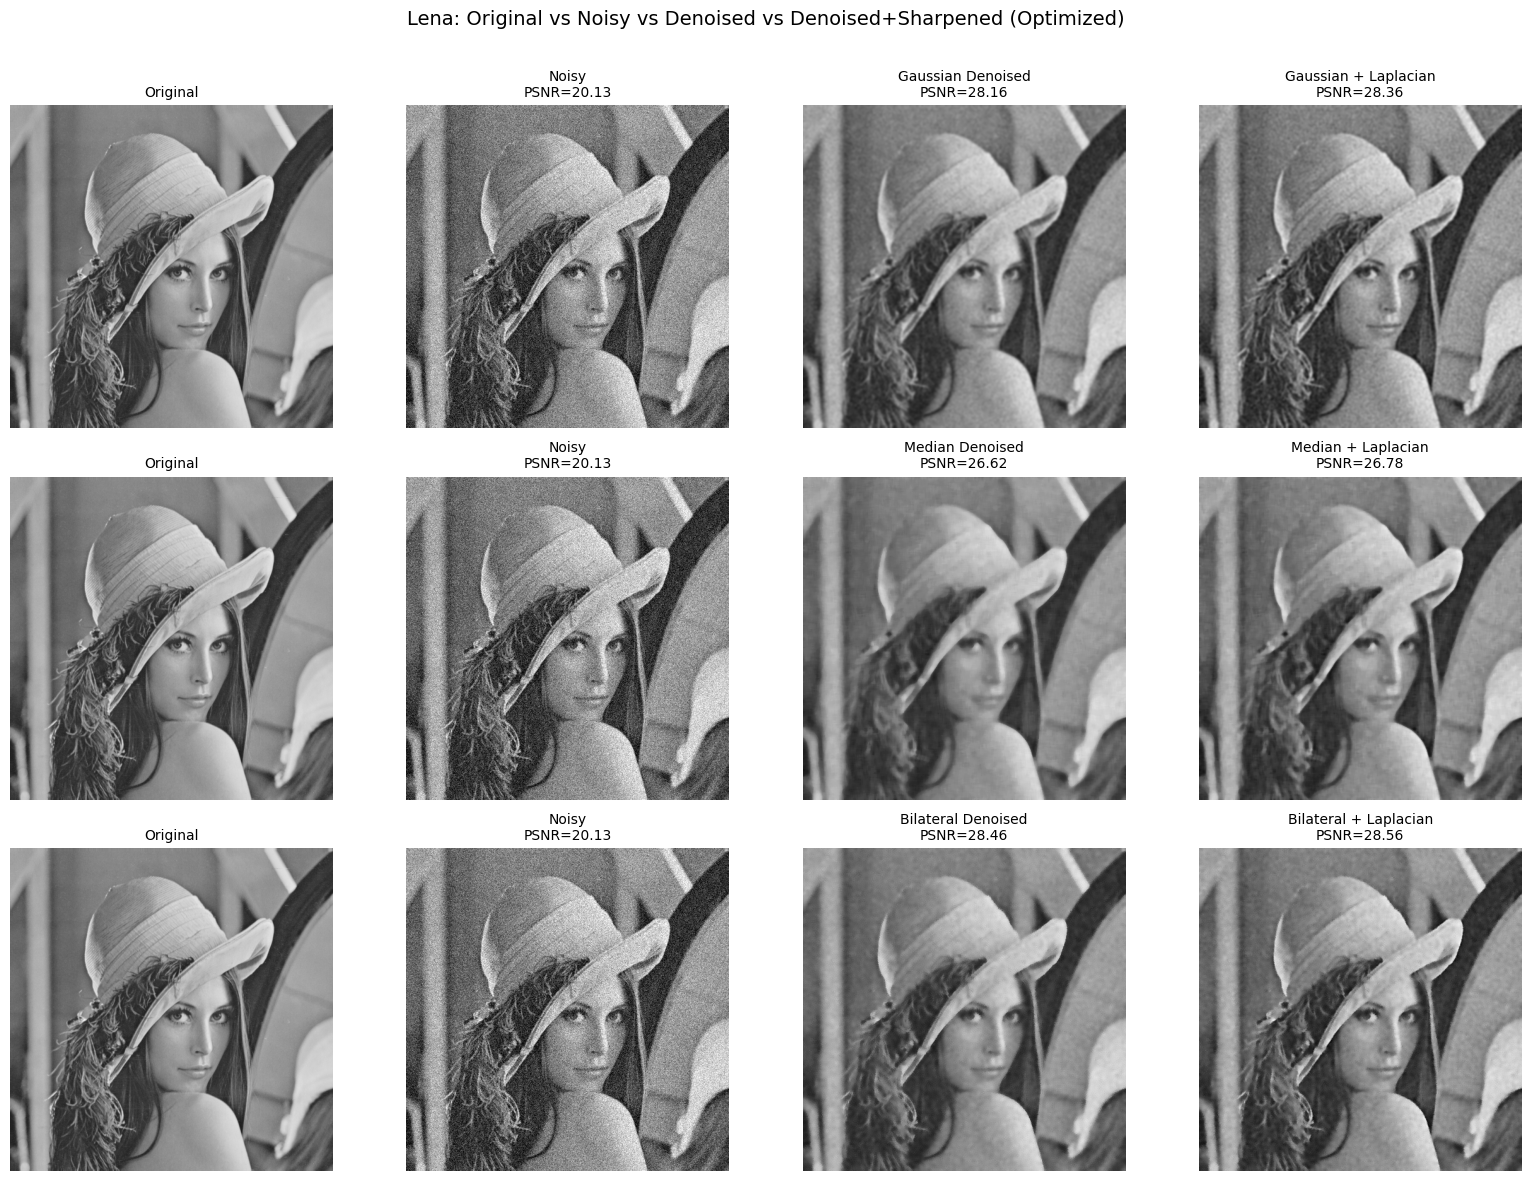

In [15]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


for name, original, noisy in image_configs:
    if noisy.shape != original.shape:
        noisy = cv2.resize(noisy, (original.shape[1], original.shape[0]))

    psnr_noisy = cv2.PSNR(original, noisy)
    denoise_results = apply_denoise_methods(name, noisy)

    fig, axes = plt.subplots(len(denoise_results), 4, figsize=(16, 12))
    fig.suptitle(f"{name}: Original vs Noisy vs Denoised vs Denoised+Sharpened (Optimized)", fontsize=14)

    for r, (method_name, denoised) in enumerate(denoise_results):
        # Apply optimized sharpening
        img_key = get_image_key(name)
        method_key = method_name.lower()
        sharpen_params = sharpen_param_sets[img_key][method_key]
        sharpened = laplacian_sharpen(denoised, **sharpen_params)

        psnr_denoised = cv2.PSNR(original, denoised)
        psnr_sharp = cv2.PSNR(original, sharpened)

        panels = [
            (original, "Original"),
            (noisy, f"Noisy\nPSNR={psnr_noisy:.2f}"),
            (denoised, f"{method_name} Denoised\nPSNR={psnr_denoised:.2f}"),
            (sharpened, f"{method_name} + Laplacian\nPSNR={psnr_sharp:.2f}"),
        ]

        for c, (img, title) in enumerate(panels):
            ax = axes[r, c]
            ax.imshow(bgr_to_rgb(img))
            ax.set_title(title, fontsize=10)
            ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [16]:
# Save the 6 sharpened final images for upload
output_dir = 'imgs'
method_suffix = {
    "Gaussian": "gaussian",
    "Median": "median",
    "Bilateral": "bilateral",
}

for name, original, noisy in image_configs:
    if noisy.shape != original.shape:
        noisy = cv2.resize(noisy, (original.shape[1], original.shape[0]))

    prefix = "goldhill" if "Goldhill" in name else "lena"
    for method_name, denoised in apply_denoise_methods(name, noisy):
        # Apply optimized sharpening
        img_key = get_image_key(name)
        method_key = method_name.lower()
        sharpen_params = sharpen_param_sets[img_key][method_key]
        sharpened = laplacian_sharpen(denoised, **sharpen_params)
        
        suffix = method_suffix[method_name]
        cv2.imwrite(os.path.join(output_dir, f'{prefix}_{suffix}_sharpened.png'), sharpened)

print("Saved 6 optimized sharpened images to imgs/")


Saved 6 optimized sharpened images to imgs/
